Эта лабораторная работа направлена на анализ уязвимостей в программном обеспечении с использованием методов машинного обучения. Основная задача – предсказать уровень риска (risk_level) уязвимости на основе данных из датасета security-patches.

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# 1. Предобработка и описание датасета

url = "https://raw.githubusercontent.com/security-commits/security-patches-dataset/refs/heads/main/dataset/security_patches_v1.0.csv"
df = pd.read_csv(url)


df.head()

,cve_id,project,sha,dataset,cwe_id,vuln_type,score,github,summary,language,vulnerable,message,author,date,comments,files,parents,ext_files,lang
0,CVE-2016-6307,https://github.com/openssl/openssl,c1ef7c971d0bbf117c3c80f65b5875e2e7b024b1,SECBENCH,CWE-400,Denial Of Service,4.3,https://github.com/openssl/openssl/commit/c1ef...,The state-machine implementation in OpenSSL 1....,c,yes,Excessive allocation of memory in tls_get_mess...,Matt Caswell,"09/19/2016, 10:39:21",{},"{'ssl/statem/statem.c': {'additions': 11, 'del...",{'41bff723c6784cc846054a4fd4add6dbec8c2c64'},{'c'},{'C/C++'}
1,NaN,https://github.com/AFNetworking/AFNetworking,c23c37ab4ab9b2401e824df717538e37bc5c85a4,SECBENCH,CWE-401,NaN,NaN,https://github.com/AFNetworking/AFNetworking/c...,NaN,m,yes,fix memory leak in NSURLSession,Oleg Naumenko,"06/18/2015, 15:07:20",{},{'AFNetworking/AFURLSessionManager.m': {'addit...,{'92006270b12ed6778095afc9d8bae9b54210df18'},{'m'},{'Objective-C'}
2,CVE-2017-6797,https://github.com/mantisbt/mantisbt,c272c3f65da9677e505ff692b1f1e476b3afa56e,SECBENCH,CWE-79,NaN,4.3,https://github.com/mantisbt/mantisbt/commit/c2...,A cross-site scripting (XSS) vulnerability in ...,php,yes,Fix XSS in bug_change_status_page.php\n\nThe v...,Damien Regad,"03/07/2017, 11:34:16",{},{'bug_change_status_page.php': {'additions': 1...,{'f8b2510febf47700b3e29b4d0c746e2d16c29487'},{'php'},{'PHP'}
3,NaN,https://github.com/joomla/joomla-cms,c277c23c617d5a9eddd2a45b7a438460d5fc6f15,SECBENCH,CWE-89,NaN,NaN,https://github.com/joomla/joomla-cms/commit/c2...,NaN,php,yes,Checking database queries for possible SQL inj...,Enno Klasing,"07/20/2007, 15:13:29",{},{'libraries/joomla/installer/adapters/componen...,{'1011d21ea64aad20ca49d266b860f1afb5ffb18c'},{'php'},{'PHP'}
4,NaN,https://github.com/curl/curl,c2a809cd265c37e7bbef55e64d70114d2f0d7189,SECBENCH,CWE-401,NaN,NaN,https://github.com/curl/curl/commit/c2a809cd26...,NaN,c,yes,formpost: fix memory leaks in AddFormData erro...,Daniel Stenberg,"02/29/2016, 19:32:08",{},"{'lib/formdata.c': {'additions': 25, 'deletion...",{'ae7d6b715448101caf99ea3555c7b7448711676e'},{'c'},{'C/C++'}


In [2]:
print("\nИнформация о датасете:")
print(df.info())
print("\nСтатистика числовых признаков:")
print(df.describe())


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8057 entries, 0 to 8056
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cve_id      7278 non-null   object 
 1   project     8057 non-null   object 
 2   sha         8057 non-null   object 
 3   dataset     8057 non-null   object 
 4   cwe_id      6908 non-null   object 
 5   vuln_type   4606 non-null   object 
 6   score       7170 non-null   float64
 7   github      8057 non-null   object 
 8   summary     7145 non-null   object 
 9   language    659 non-null    object 
 10  vulnerable  8057 non-null   object 
 11  message     8047 non-null   object 
 12  author      8054 non-null   object 
 13  date        8057 non-null   object 
 14  comments    8057 non-null   object 
 15  files       8057 non-null   object 
 16  parents     8057 non-null   object 
 17  ext_files   7883 non-null   object 
 18  lang        7643 non-null   object 
dtypes: 


Количество пропусков до обработки:
cve_id         779
project          0
dataset          0
cwe_id        1149
vuln_type     3451
score          887
language      7398
vulnerable       0
files            0
lang           414
dtype: int64


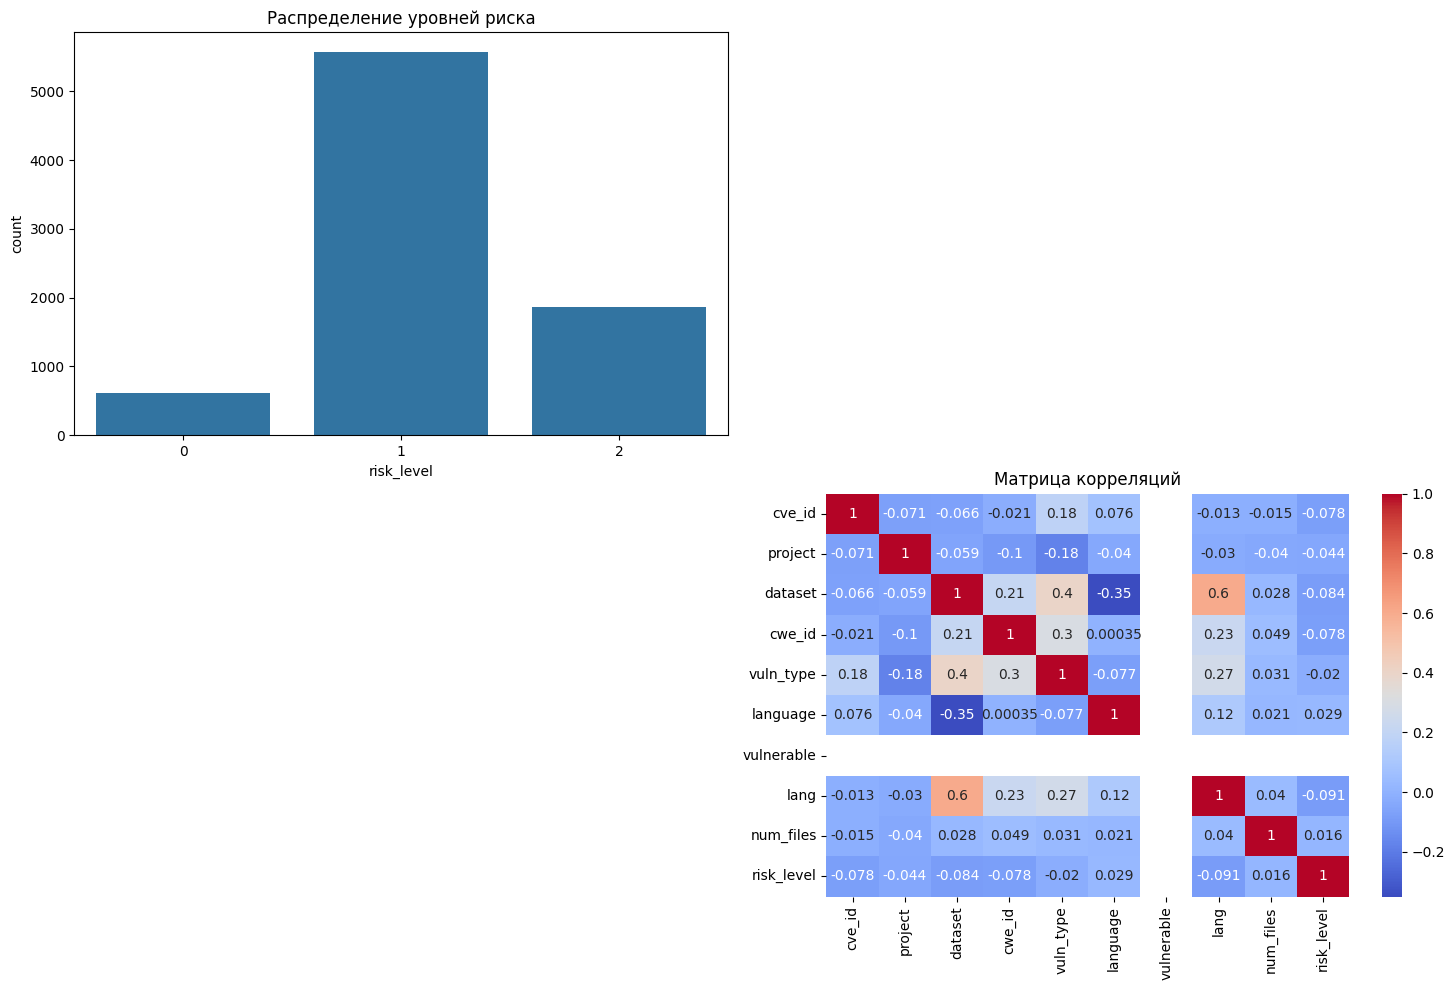

X_train:        cve_id  cwe_id  vuln_type  vulnerable  lang  num_files
4512    4527      43        115           1    69         27
6515    3616      98        115           1    89         20
2860     163      23        115           1     8         16
1003    2267      33          6           1    33          1
5493    5482      31        115           1    76          1
...      ...     ...        ...         ...   ...        ...
5226    1297      33        115           1    76          1
5390    5710      23        115           1    97          5
860     2911       9         27           1    33          6
7603    2050      70        115           1    33          1
7270    1217     133         79           1   103          2

[5639 rows x 6 columns]
Y_train:  4512    1
6515    1
2860    1
1003    2
5493    1
       ..
5226    1
5390    1
860     1
7603    1
7270    1
Name: risk_level, Length: 5639, dtype: category
Categories (3, int64): [0 < 1 < 2]

Random Forest Classification 

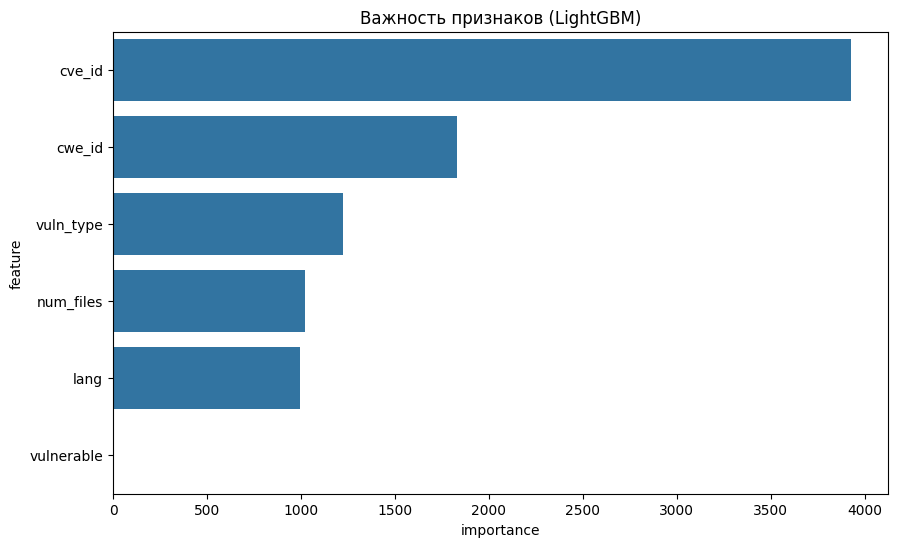

In [4]:
# Очистка данных
# Удаление нефункциональных столбцов
cols_to_drop = ['sha', 'github', 'summary', 'message',
                'author', 'date', 'comments', 'parents', 'ext_files']
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# Обработка пропусков
print("\nКоличество пропусков до обработки:")
print(df_clean.isna().sum())

# Заполнение пропусков
df_clean['score'] = df_clean['score'].fillna(df_clean['score'].median())
df_clean['vuln_type'] = df_clean['vuln_type'].fillna('unknown')
df_clean['language'] = df_clean['language'].fillna(df_clean['language'].mode()[0])
df_clean['vulnerable'] = df_clean['vulnerable'].fillna(False)
df_clean['cve_id'] = df_clean['cve_id'].fillna(df_clean['cve_id'].mode()[0])

# Извлечение новых признаков
df_clean['num_files'] = df_clean['files'].apply(lambda x: len(eval(x)) if pd.notna(x) else 0)
df_clean = df_clean.drop(columns=['files'])

# Преобразование категориальных признаков
df_clean['vulnerable'] = df_clean['vulnerable'].apply(lambda x: 1 if str(x).lower() in ['yes', 'true'] else 0)
# Кодирование категориальных переменных
cat_cols = ['project', 'dataset', 'cwe_id', 'vuln_type', 'language', 'lang','cve_id']
for col in cat_cols:
    if col in df_clean.columns:
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))

# Преобразование целевой переменной в категории
bins = [0, 3.9, 6.9, 10]
labels = [0, 1, 2]  # 0-низкий, 1-средний, 2-высокий
df_clean['risk_level'] = pd.cut(df_clean['score'], bins=bins, labels=labels, include_lowest=True)
df_clean = df_clean.drop(columns=['score'])

# Визуализация
plt.figure(figsize=(15, 10))

# Распределение уровней риска
plt.subplot(2, 2, 1)
sns.countplot(data=df_clean, x='risk_level')
plt.title('Распределение уровней риска')


# Корреляция признаков
plt.subplot(2, 2, 4)
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')

plt.tight_layout()
plt.show()

# 2. Выбор признакового пространства

# Выделение признаков и целевой переменной
X = df_clean.drop(columns=['risk_level', 'project','dataset','language'])
y = df_clean['risk_level']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train: ", X_train)
print(f"Y_train: ",y_train)


# 3. Выбор модели машинного обучения

# Инициализация моделей
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
}

# Обучение и оценка моделей
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = f1
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Вывод результатов
print("\nF1-score результатов:")
for name, score in results.items():
    print(f"{name}: {score:.4f}")

# Выбор лучшей модели
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nЛучшая модель: {best_model_name} с F1-score: {results[best_model_name]:.4f}")

# Важность признаков (для tree-based моделей)
if hasattr(best_model, 'feature_importances_'):
    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importances, x='importance', y='feature')
    plt.title(f'Важность признаков ({best_model_name})')
    plt.show()